# Notebook de Experimentación de Clustering: Descubrimiento de Categorías de Tweets


## Objetivo

El propósito de este notebook es realizar un análisis de clustering sobre los embeddings de los tweets del conjunto de "discovery" (entrenamiento). El objetivo principal es identificar agrupaciones naturales en los datos que puedan ser interpretadas como categorías temáticas relevantes para la atención al cliente. Este proceso nos ayudará a:

1.  Determinar un número óptimo de clústeres (`k`) para el algoritmo K-Means.
2.  Analizar las características de cada clúster (palabras clave, tweets de muestra) para asignarles nombres de categoría significativos.
3.  Generar la información necesaria para el paso de pseudo-etiquetado en el pipeline principal (`src/clustering.py`).

Este notebook es un espacio de experimentación y análisis exploratorio. Los hallazgos aquí informarán la configuración del script de clustering automatizado.

## 0.1 Importaciones y Configuración Inicial

In [13]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.auto import tqdm
import logging
import joblib 
from typing import List, Dict, Tuple, Optional, Any

# Configuración para que los plots se muestren en el notebook
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6) # Ajustar tamaño de plots
plt.rcParams['font.size'] = 12 

# Añadir la carpeta 'src' al path para importar config.py
module_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Añadido '{module_path}' a sys.path")

try:
    import config 
    print("Módulo config.py cargado exitosamente desde src.")
except ImportError as e:
    print(f"Error importando config.py desde src: {e}")
    print("Asegúrate de que config.py esté en la carpeta src y que el path sea correcto.")
    print("Definiendo una configuración mock para continuar (¡SOLO PARA DESARROLLO DEL NOTEBOOK SI FALLA LA IMPORTACIÓN!).")
    class MockConfig: # Inicio de Configuración Mock
        RANDOM_STATE = 42
        KMEANS_INIT_METHOD = 'k-means++'
        KMEANS_N_INIT = 10 
        KMEANS_MAX_ITER_ELBOW = 150
        KMEANS_MAX_ITER = 300       
        EMBEDDINGS_REDUCED_OUTPUT_PATHS = {'discovery': '../data/04_features/discovery_embeddings_reduced_pca_50d.npy'}
        EMBEDDINGS_IDS_OUTPUT_PATHS = {'discovery': '../data/04_features/discovery_embeddings_ids_pca_50d.csv'}
        PREPROCESSED_OUTPUT_PATHS = {'discovery': '../data/03_preprocessed_text/discovery_preprocessed.csv'}
        COL_TWEET_ID = 'tweet_id'
        COL_TEXT = 'text'
        COL_PREPROCESSED_TEXT = 'text_preprocessed'
        MODELS_DIR = '../models'
        KMEANS_K_RANGE_START = 2 # Usado por tu código de experimentación si no se definen los _NB
        KMEANS_K_RANGE_END = 15 
        PREPROCESSING_REMOVE_STOPWORDS = True 
        KMEANS_N_CLUSTERS = 8 
        LOGGING_LEVEL = logging.INFO
        LOGGING_FORMAT = '%(asctime)s - %(levelname)s - %(name)s - %(funcName)s - %(message)s'
        LOGGING_DATE_FORMAT = '%Y-%m-%d %H:%M:%S'
        def setup_logging(self):
            logger = logging.getLogger()
            if not logger.handlers:
                 logging.basicConfig(level=self.LOGGING_LEVEL, format=self.LOGGING_FORMAT, datefmt=self.LOGGING_DATE_FORMAT)
    config = MockConfig() # Fin de Configuración Mock

config.setup_logging() 
logging.info("Notebook de Experimentación de Clustering Iniciado.")

2025-05-21 10:52:38 - INFO - root - 2616592731.<module>:62 - Notebook de Experimentación de Clustering Iniciado.


Módulo config.py cargado exitosamente desde src.


## 1. Carga de Datos para Clustering

Para este análisis, utilizaremos los **embeddings reducidos por PCA** (a 50 dimensiones, según `config.PCA_N_COMPONENTS`) que fueron generados a partir de los textos preprocesados del conjunto de datos `discovery`.

También cargaremos:
* El archivo CSV con los **IDs de los tweets** correspondientes a estos embeddings (`config.EMBEDDINGS_IDS_OUTPUT_PATHS['discovery']`).
* El archivo CSV con los **textos preprocesados** y **textos originales** del conjunto `discovery` (`config.PREPROCESSED_OUTPUT_PATHS['discovery']`), para el análisis cualitativo posterior de los clústeres.

In [14]:
logging.info("Cargando embeddings reducidos, IDs y textos para el conjunto 'discovery'...")

embeddings_path_discovery = config.EMBEDDINGS_REDUCED_OUTPUT_PATHS.get("discovery")
if not embeddings_path_discovery or not os.path.exists(embeddings_path_discovery):
    logging.error(f"Ruta de embeddings reducidos para 'discovery' no encontrada: {embeddings_path_discovery}")
    raise FileNotFoundError(f"Archivo de embeddings no encontrado: {embeddings_path_discovery}. Ejecuta feature_engineering.py primero.")
try:
    embeddings_discovery = np.load(embeddings_path_discovery)
    logging.info(f"Embeddings de 'discovery' cargados. Forma: {embeddings_discovery.shape}")
except Exception as e:
    logging.error(f"Error cargando embeddings de discovery desde {embeddings_path_discovery}: {e}")
    raise

ids_path_discovery = config.EMBEDDINGS_IDS_OUTPUT_PATHS.get("discovery")
if not ids_path_discovery or not os.path.exists(ids_path_discovery):
    logging.error(f"Ruta de IDs de embeddings para 'discovery' no encontrada: {ids_path_discovery}")
    raise FileNotFoundError(f"Archivo de IDs de embeddings no encontrado: {ids_path_discovery}. Ejecuta feature_engineering.py primero.")
try:
    df_ids_discovery = pd.read_csv(ids_path_discovery)
    logging.info(f"IDs de 'discovery' cargados. Total: {len(df_ids_discovery)}")
except Exception as e:
    logging.error(f"Error cargando IDs de discovery desde {ids_path_discovery}: {e}")
    raise

if embeddings_discovery.shape[0] != len(df_ids_discovery):
    error_msg = (f"Inconsistencia: Número de embeddings ({embeddings_discovery.shape[0]}) "
                 f"no coincide con número de IDs ({len(df_ids_discovery)}).")
    logging.error(error_msg)
    raise ValueError(error_msg)

preprocessed_texts_path_discovery = config.PREPROCESSED_OUTPUT_PATHS.get("discovery")
df_discovery_context_aligned = None 
if not preprocessed_texts_path_discovery or not os.path.exists(preprocessed_texts_path_discovery):
    logging.warning(f"Archivo de textos preprocesados no encontrado: {preprocessed_texts_path_discovery}. Análisis de keywords usará placeholders.")
    df_discovery_context_aligned = df_ids_discovery.copy()
    if config.COL_PREPROCESSED_TEXT not in df_discovery_context_aligned.columns:
        df_discovery_context_aligned[config.COL_PREPROCESSED_TEXT] = "TEXTO_PREPROCESADO_NO_DISPONIBLE"
    if config.COL_TEXT not in df_discovery_context_aligned.columns:
        df_discovery_context_aligned[config.COL_TEXT] = "TEXTO_ORIGINAL_NO_DISPONIBLE"
else:
    try:
        df_preprocessed_texts_discovery = pd.read_csv(preprocessed_texts_path_discovery)
        text_cols_to_select = [config.COL_TWEET_ID]
        if config.COL_TEXT in df_preprocessed_texts_discovery.columns: text_cols_to_select.append(config.COL_TEXT)
        if config.COL_PREPROCESSED_TEXT in df_preprocessed_texts_discovery.columns: text_cols_to_select.append(config.COL_PREPROCESSED_TEXT)
        
        df_discovery_context_aligned = pd.merge(df_ids_discovery, 
                                                df_preprocessed_texts_discovery[text_cols_to_select], 
                                                on=config.COL_TWEET_ID, how='left')
        
        if config.COL_PREPROCESSED_TEXT in df_discovery_context_aligned.columns:
             df_discovery_context_aligned[config.COL_PREPROCESSED_TEXT] = df_discovery_context_aligned[config.COL_PREPROCESSED_TEXT].fillna("TEXTO_PREPROCESADO_FALTANTE")
        else: df_discovery_context_aligned[config.COL_PREPROCESSED_TEXT] = "TEXTO_PREPROCESADO_NO_CARGADO"
        if config.COL_TEXT in df_discovery_context_aligned.columns:
            df_discovery_context_aligned[config.COL_TEXT] = df_discovery_context_aligned[config.COL_TEXT].fillna("TEXTO_ORIGINAL_FALTANTE")
        else: df_discovery_context_aligned[config.COL_TEXT] = "TEXTO_ORIGINAL_NO_CARGADO"
        logging.info(f"Textos de 'discovery' cargados y unidos. Filas en contexto: {len(df_discovery_context_aligned)}")
    except Exception as e:
        logging.error(f"Error cargando/uniendo textos de discovery: {e}", exc_info=True)
        raise

# Esta es la variable que tu código de experimentación de k espera
embeddings_to_cluster = embeddings_discovery 
# Y esta es la que usaremos consistentemente en el resto del notebook
X_cluster = embeddings_discovery 

logging.info(f"Forma de X_cluster (embeddings para clustering): {X_cluster.shape}")
logging.info(f"Forma de df_discovery_context_aligned (para análisis): {df_discovery_context_aligned.shape}")
print("Primeras filas del DataFrame de contexto (df_discovery_context_aligned):")
print(df_discovery_context_aligned.head())

2025-05-21 10:52:43 - INFO - root - 3662904328.<module>:1 - Cargando embeddings reducidos, IDs y textos para el conjunto 'discovery'...
2025-05-21 10:52:43 - INFO - root - 3662904328.<module>:9 - Embeddings de 'discovery' cargados. Forma: (1076490, 50)
2025-05-21 10:52:43 - INFO - root - 3662904328.<module>:20 - IDs de 'discovery' cargados. Total: 1076490
2025-05-21 10:52:52 - INFO - root - 3662904328.<module>:57 - Textos de 'discovery' cargados y unidos. Filas en contexto: 1076490
2025-05-21 10:52:52 - INFO - root - 3662904328.<module>:67 - Forma de X_cluster (embeddings para clustering): (1076490, 50)
2025-05-21 10:52:52 - INFO - root - 3662904328.<module>:68 - Forma de df_discovery_context_aligned (para análisis): (1076490, 3)


Primeras filas del DataFrame de contexto (df_discovery_context_aligned):
   tweet_id                                               text  \
0    601403  My iPhone keeps crashing after update @115858 ...   
1   1735612  And now @115821 is TEXTING me book recommendat...   
2   2160580  @Delta how does one find out if they’re at T2 ...   
3   2100546                                @620349 @UPSHelp 😂😂   
4    424721                          @ChipotleTweets @216079 😭   

                                   text_preprocessed  
0  my iphone keep crash after update keep do this...  
1  and now be texting me book recommendation i do...  
2  how do one find out if they ’ re at t2 or t4 a...  
3  emoji_face_with_tears_of_joy emoji_face_with_t...  
4                           emoji_loudly_crying_face  


## 2. Determinación del Número Óptimo de Clústeres (k) para K-Means

Para encontrar un `k` adecuado, evaluaremos el rendimiento de K-Means para un rango de valores de `k` utilizando varias métricas:

1.  **Método del Codo (WCSS - Inertia):** Mide la suma de las distancias al cuadrado de las muestras a su centro de clúster más cercano. Buscamos un "codo" donde añadir más clústeres no reduce significativamente la WCSS. Se calcula sobre el conjunto completo de embeddings.
2.  **Coeficiente de Silueta:** Mide qué tan similar es un objeto a su propio clúster en comparación con otros clústeres. Un valor más alto es mejor (cercano a 1).
3.  **Índice Calinski-Harabasz:** También conocido como el criterio de Ratio de Varianza. Un valor más alto indica clústeres mejor definidos.
4.  **Índice Davies-Bouldin:** Mide la similitud promedio entre cada clúster y su clúster más similar. Un valor más bajo indica una mejor partición (clústeres más separados).

Debido al costo computacional, las métricas de Silueta, Calinski-Harabasz y Davies-Bouldin se calcularán sobre una muestra de los embeddings si el dataset es muy grande.

2025-05-21 10:19:34 - INFO - root - 2816362782.<module>:7 - Tomando una muestra de 50000 puntos para calcular Silhouette, Calinski-Harabasz y Davies-Bouldin.
2025-05-21 10:19:34 - INFO - root - 2816362782.<module>:33 - Calculando métricas de K-Means para k en el rango: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Probando valores de k:   0%|          | 0/16 [00:00<?, ?it/s]

2025-05-21 10:19:50 - INFO - root - 2816362782.<module>:69 - k=5, Silhouette: 0.1249, CH: 2593.22, DB: 3.1343
2025-05-21 10:20:12 - INFO - root - 2816362782.<module>:69 - k=6, Silhouette: 0.1217, CH: 2420.38, DB: 3.0281
2025-05-21 10:20:31 - INFO - root - 2816362782.<module>:69 - k=7, Silhouette: 0.1217, CH: 2215.45, DB: 3.1045
2025-05-21 10:20:48 - INFO - root - 2816362782.<module>:69 - k=8, Silhouette: 0.1151, CH: 1984.36, DB: 3.1758
2025-05-21 10:21:05 - INFO - root - 2816362782.<module>:69 - k=9, Silhouette: 0.1165, CH: 1877.38, DB: 3.1444
2025-05-21 10:21:21 - INFO - root - 2816362782.<module>:69 - k=10, Silhouette: 0.1119, CH: 1764.27, DB: 3.1096
2025-05-21 10:21:39 - INFO - root - 2816362782.<module>:69 - k=11, Silhouette: 0.1165, CH: 1659.98, DB: 3.0635
2025-05-21 10:21:56 - INFO - root - 2816362782.<module>:69 - k=12, Silhouette: 0.1106, CH: 1591.56, DB: 2.9703
2025-05-21 10:22:17 - INFO - root - 2816362782.<module>:69 - k=13, Silhouette: 0.1143, CH: 1520.02, DB: 2.9138
2025-0

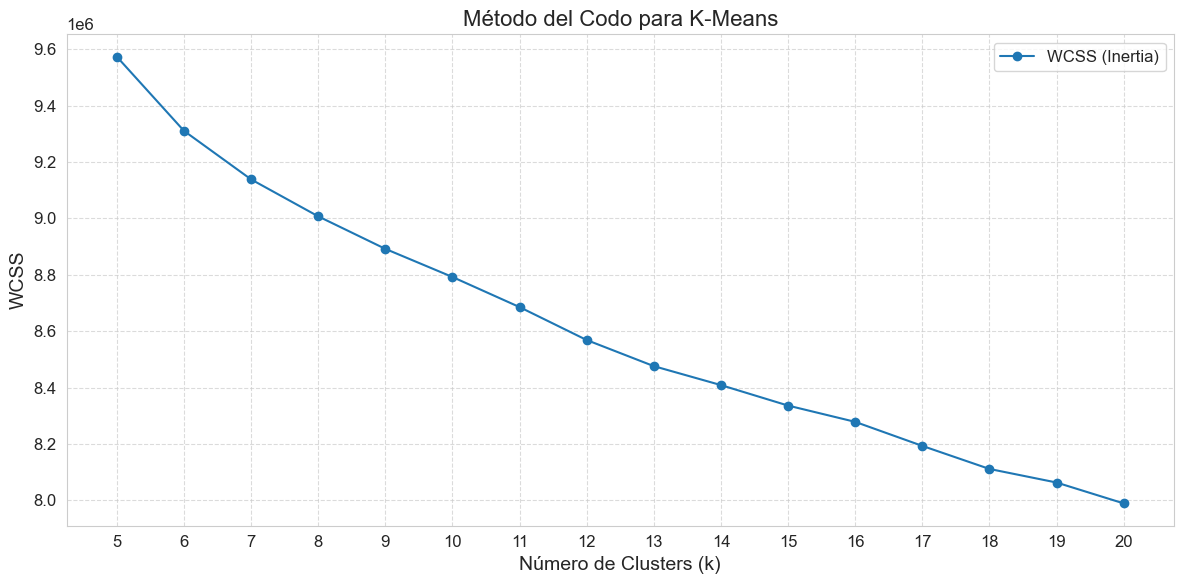

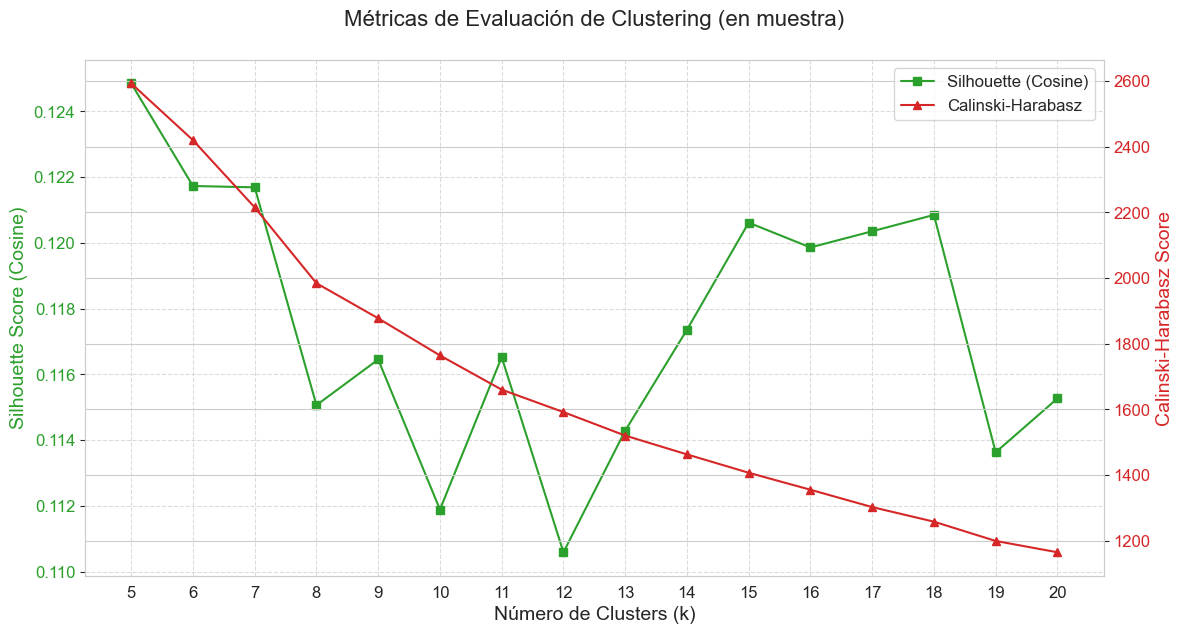

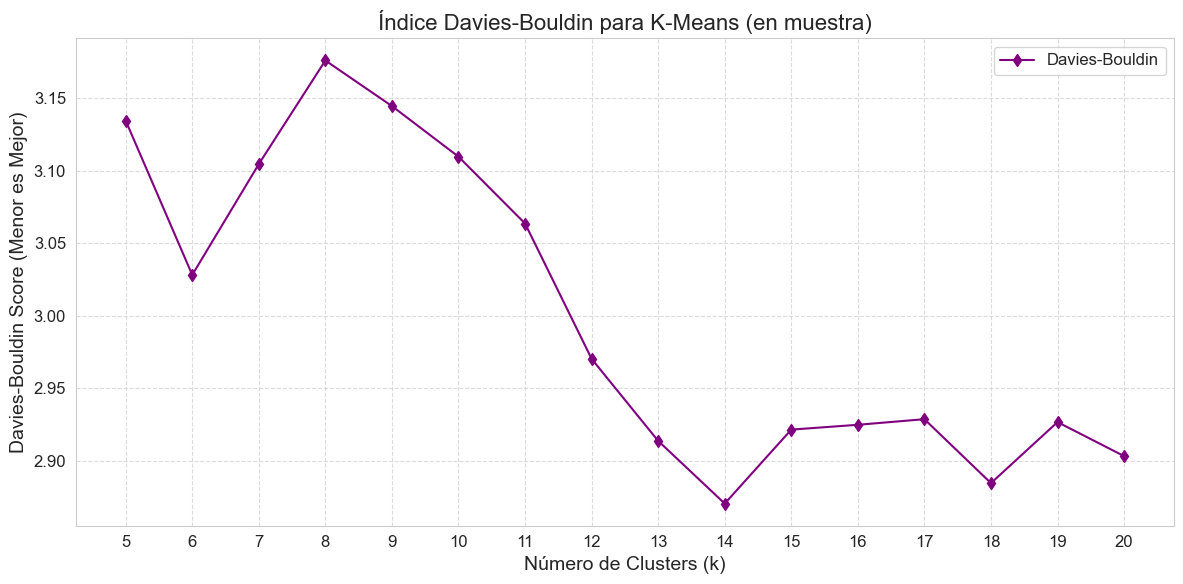


Tabla Resumen de Métricas de Clustering:
     k       WCSS  Silhouette (Cosine)  Calinski-Harabasz  Davies-Bouldin
0    5  9573335.0             0.124853        2593.216797        3.134346
1    6  9310519.0             0.121733        2420.376953        3.028105
2    7  9138354.0             0.121692        2215.452393        3.104460
3    8  9007326.0             0.115064        1984.356079        3.175828
4    9  8891989.0             0.116453        1877.380371        3.144422
5   10  8792232.0             0.111887        1764.273193        3.109559
6   11  8685450.0             0.116524        1659.979980        3.063522
7   12  8568622.0             0.110587        1591.563110        2.970295
8   13  8476077.0             0.114288        1520.024048        2.913763
9   14  8408830.0             0.117357        1462.654541        2.870580
10  15  8336193.5             0.120618        1406.693726        2.921527
11  16  8278447.0             0.119863        1354.895386        2.924

In [11]:
# Para datasets grandes, calcular Silhouette y otras métricas en todo el dataset puede ser muy lento.
# Haremos el cálculo del codo en todo, y las otras métricas en una muestra.
sample_size_for_metrics = min(50000, X_cluster.shape[0]) # X_cluster es embeddings_to_cluster
embeddings_sample_for_metrics = X_cluster # Por defecto, usar todos

if X_cluster.shape[0] > sample_size_for_metrics:
    logging.info(f"Tomando una muestra de {sample_size_for_metrics} puntos para calcular Silhouette, Calinski-Harabasz y Davies-Bouldin.")
    np.random.seed(getattr(config, 'RANDOM_STATE', 42)) 
    sample_indices = np.random.choice(X_cluster.shape[0], size=sample_size_for_metrics, replace=False)
    embeddings_sample_for_metrics = X_cluster[sample_indices]
else:
    logging.info(f"Usando el dataset completo ({X_cluster.shape[0]} muestras) para Silhouette, Calinski-Harabasz y Davies-Bouldin.")


# --- Parámetros de K-Means para esta experimentación de k ---
KMEANS_N_CLUSTERS_START_NB = getattr(config, 'KMEANS_K_RANGE_START', 5)
KMEANS_N_CLUSTERS_END_NB = getattr(config, 'KMEANS_K_RANGE_END', 20)
KMEANS_N_CLUSTERS_STEP_NB = 1 # Asumiendo paso de 1
KMEANS_INIT_NB = getattr(config, 'KMEANS_INIT_METHOD', 'k-means++')
KMEANS_N_INIT_NB = getattr(config, 'KMEANS_N_INIT', 'auto' if hasattr(KMeans(), 'n_init') and KMeans().n_init == 'auto' else 10) # 'auto' o 10
KMEANS_MAX_ITER_NB_ELBOW = getattr(config, 'KMEANS_MAX_ITER_ELBOW', 150) # Para el codo
KMEANS_MAX_ITER_NB_METRICS = getattr(config, 'KMEANS_MAX_ITER', 300) # Para otras métricas
RANDOM_STATE_NB = getattr(config, 'RANDOM_STATE', 42)
# -------------------------------------------------------------

k_range = range(KMEANS_N_CLUSTERS_START_NB, KMEANS_N_CLUSTERS_END_NB + 1, KMEANS_N_CLUSTERS_STEP_NB)

wcss = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

logging.info(f"Calculando métricas de K-Means para k en el rango: {list(k_range)}")
for k_val in tqdm(k_range, desc="Probando valores de k"):
    # Modelo para WCSS (puede usar menos iteraciones y se ajusta en el dataset completo)
    kmeans_wcss = KMeans(
        n_clusters=k_val,
        init=KMEANS_INIT_NB,
        n_init=KMEANS_N_INIT_NB,
        max_iter=KMEANS_MAX_ITER_NB_ELBOW, # Menos iteraciones para el codo
        random_state=RANDOM_STATE_NB
    )
    kmeans_wcss.fit(X_cluster) # Ajustar en el dataset completo para WCSS
    wcss.append(kmeans_wcss.inertia_)

    # Modelo para otras métricas (se ajusta y evalúa en la muestra)
    # Solo calcular si k_val >= 2 (necesario para estas métricas)
    if k_val < 2:
        silhouette_scores.append(np.nan)
        calinski_harabasz_scores.append(np.nan)
        davies_bouldin_scores.append(np.nan)
        logging.info(f"k={k_val}, Métricas (Silhouette, CH, DB) no aplicables.")
        continue

    if embeddings_sample_for_metrics.shape[0] >= k_val : # Necesitamos al menos k muestras para k clusters
        kmeans_metrics = KMeans(
            n_clusters=k_val,
            init=KMEANS_INIT_NB,
            n_init=KMEANS_N_INIT_NB,
            max_iter=KMEANS_MAX_ITER_NB_METRICS, # Más iteraciones para el modelo de métricas
            random_state=RANDOM_STATE_NB
        )
        cluster_labels_sample = kmeans_metrics.fit_predict(embeddings_sample_for_metrics)
        
        if len(np.unique(cluster_labels_sample)) > 1: # Necesitamos al menos 2 clusters formados
            silhouette_scores.append(silhouette_score(embeddings_sample_for_metrics, cluster_labels_sample, metric='cosine'))
            calinski_harabasz_scores.append(calinski_harabasz_score(embeddings_sample_for_metrics, cluster_labels_sample))
            davies_bouldin_scores.append(davies_bouldin_score(embeddings_sample_for_metrics, cluster_labels_sample))
            logging.info(f"k={k_val}, Silhouette: {silhouette_scores[-1]:.4f}, CH: {calinski_harabasz_scores[-1]:.2f}, DB: {davies_bouldin_scores[-1]:.4f}")
        else:
            silhouette_scores.append(np.nan)
            calinski_harabasz_scores.append(np.nan)
            davies_bouldin_scores.append(np.nan)
            logging.warning(f"k={k_val}, Solo se formó 1 clúster en la muestra. Métricas no válidas.")
    else:
        silhouette_scores.append(np.nan)
        calinski_harabasz_scores.append(np.nan)
        davies_bouldin_scores.append(np.nan)
        logging.warning(f"k={k_val}, No hay suficientes muestras ({embeddings_sample_for_metrics.shape[0]}) para {k_val} clústeres en la muestra.")

# Graficar el Método del Codo
plt.figure()
plt.plot(list(k_range), wcss, marker='o', label='WCSS (Inertia)')
plt.title('Método del Codo para K-Means', fontsize=16)
plt.xlabel('Número de Clusters (k)', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.xticks(list(k_range))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Graficar Métricas Adicionales
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Número de Clusters (k)', fontsize=14)
ax1.set_ylabel('Silhouette Score (Cosine)', color=color, fontsize=14)
ax1.plot(list(k_range), silhouette_scores, marker='s', color=color, label='Silhouette (Cosine)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(list(k_range))
ax1.grid(True, linestyle='--', alpha=0.7)

ax2 = ax1.twinx()  # Instanciar un segundo eje que comparte el mismo eje x
color = 'tab:red'
ax2.set_ylabel('Calinski-Harabasz Score', color=color, fontsize=14)  
ax2.plot(list(k_range), calinski_harabasz_scores, marker='^', color=color, label='Calinski-Harabasz')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() # Para que el ylabel derecho no se corte
plt.title('Métricas de Evaluación de Clustering (en muestra)', fontsize=16, y=1.05) # Ajustar y para que no solape
# Añadir leyendas combinadas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')
plt.show()

plt.figure()
plt.plot(list(k_range), davies_bouldin_scores, marker='d', color='purple', label='Davies-Bouldin')
plt.title('Índice Davies-Bouldin para K-Means (en muestra)', fontsize=16)
plt.xlabel('Número de Clusters (k)', fontsize=14)
plt.ylabel('Davies-Bouldin Score (Menor es Mejor)', fontsize=14)
plt.xticks(list(k_range))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar tabla de métricas
df_k_eval_metrics = pd.DataFrame({
    'k': list(k_range),
    'WCSS': wcss,
    'Silhouette (Cosine)': silhouette_scores,
    'Calinski-Harabasz': calinski_harabasz_scores,
    'Davies-Bouldin': davies_bouldin_scores
})
print("\nTabla Resumen de Métricas de Clustering:")
print(df_k_eval_metrics.to_string())

## 3. Selección de `k` y Aplicación Final de K-Means

Tras analizar las gráficas y la tabla de métricas:

* **Observaciones del Método del Codo (WCSS):** La gráfica del codo muestra una disminución progresiva del WCSS conforme aumenta el número de clústeres, sin un “codo” claro y marcado. Sin embargo, hay un cambio de pendiente ligeramente más notorio alrededor de k=8, lo que sugiere que a partir de este valor la ganancia marginal en la reducción del WCSS disminuye.
* **Observaciones del Coeficiente de Silueta (Cosine):** El coeficiente de silueta (usando distancia coseno) alcanza su valor más alto en k=5, pero rápidamente cae a partir de ahí. A pesar de algunas oscilaciones, se observa una recuperación y estabilización moderada en k=15 a k=18. No obstante, entre k=8 y k=11 los valores se mantienen razonablemente consistentes (~0.115-0.117), lo que sugiere una calidad aceptable de los clústeres en esa región sin caer en la sobresegmentación.
* **Observaciones del Índice Calinski-Harabasz:** Este índice, que mide la separación entre clústeres, tiene su valor más alto en k=5 y desciende de manera constante a medida que aumenta el número de clústeres. Aunque esto podría sugerir un mejor agrupamiento en k bajos, en combinación con las otras métricas, k=8 representa un equilibrio razonable entre separación y cohesión.
* **Observaciones del Índice Davies-Bouldin (Menor es Mejor):** El Davies-Bouldin score muestra una tendencia general a disminuir (mejorar) a medida que se incrementa k. Se alcanza un mínimo local en k=14, pero ya desde k=8 comienza una mejora progresiva. k=8 representa un punto donde el índice baja de forma sostenida respecto a valores anteriores, sin incurrir en una complejidad excesiva del modelo.

**Decisión Final para `k_optimo`:** Basado en la convergencia de estas métricas y considerando la necesidad de mantener interpretabilidad en la segmentación (por ejemplo, 8 categorías de atención al cliente), se selecciona k_optimo = 8 como el número de clústeres para el análisis final. Este valor ofrece un equilibrio adecuado entre compacidad, separación y simplicidad.

Este valor ya está configurado como config.KMEANS_N_CLUSTERS en el archivo src/config.py para el pipeline principal.

A continuación, aplicaremos K-Means con k=8 a la totalidad de los embeddings reducidos del conjunto discovery para obtener las asignaciones de clúster definitivas.

In [15]:
k_optimo = 8 # K óptimo
logging.info(f"Valor de k seleccionado para el clustering final: {k_optimo}")

if config.KMEANS_N_CLUSTERS != k_optimo:
    logging.warning(f"El k_optimo definido en el notebook ({k_optimo}) difiere de config.KMEANS_N_CLUSTERS ({config.KMEANS_N_CLUSTERS}). "
                    f"Para el pipeline, se usará el valor de config.py. Este notebook es para exploración y validación.")

kmeans_final_model = KMeans(n_clusters=k_optimo,
                            init=config.KMEANS_INIT_METHOD,
                            n_init=config.KMEANS_N_INIT,
                            max_iter=config.KMEANS_MAX_ITER,
                            random_state=config.RANDOM_STATE,
                            verbose=0)

logging.info(f"Ajustando modelo K-Means final con k={k_optimo} en todos los datos de X_cluster (discovery)... ")
# X_cluster son los embeddings completos de discovery
cluster_labels_discovery = kmeans_final_model.fit_predict(X_cluster) 
logging.info("Modelo K-Means final ajustado y etiquetas de clúster generadas.")

# Añadir las etiquetas de clúster al DataFrame de contexto de discovery
df_discovery_with_clusters = None # Inicializar
# Es crucial que df_discovery_context_aligned y X_cluster (y por tanto cluster_labels_discovery)
# tengan el mismo número de filas y estén en el mismo orden.
# La carga de datos en la Celda 5 se encarga de esto.
if 'df_discovery_context_aligned' in locals() and df_discovery_context_aligned is not None and \
   len(df_discovery_context_aligned) == len(cluster_labels_discovery):
    
    df_discovery_with_clusters = df_discovery_context_aligned.copy()
    df_discovery_with_clusters['cluster_id'] = cluster_labels_discovery
    logging.info("Etiquetas de clúster añadidas al DataFrame de contexto de discovery.")
    
    cluster_distribution = df_discovery_with_clusters['cluster_id'].value_counts().sort_index()
    logging.info(f"Distribución de tweets por clúster en 'discovery' (k={k_optimo}):\n{cluster_distribution}")
    print(f"\nDistribución de tweets por clúster (k={k_optimo}):")
    print(cluster_distribution)

    # Guardar el modelo KMeans ajustado (opcional en el notebook, ya que el script `clustering.py` lo hace)
    # Esta ruta debe coincidir con la que usa `clustering.py` para cargar (config.DISCOVERY_KMEANS_MODEL_PATH_OFFICIAL 
    # o construida con la plantilla config.CLUSTER_MODEL_OUTPUT_PATHS['discovery_template'].format(k=k_optimo))
    # Por simplicidad, usaremos KMEANS_N_CLUSTERS de config para el nombre del archivo "oficial"
    if hasattr(config, 'DISCOVERY_KMEANS_MODEL_PATH_OFFICIAL'):
        official_kmeans_model_path = config.DISCOVERY_KMEANS_MODEL_PATH_OFFICIAL
    elif hasattr(config, 'CLUSTER_MODEL_OUTPUT_PATHS') and "discovery_template" in config.CLUSTER_MODEL_OUTPUT_PATHS:
        official_kmeans_model_path = config.CLUSTER_MODEL_OUTPUT_PATHS["discovery_template"].format(k=config.KMEANS_N_CLUSTERS)
    else: # Fallback si las rutas de config no están como se espera
        official_kmeans_model_path = os.path.join(config.MODELS_DIR, "clustering", f"discovery_clustering_model_kmeans_k{config.KMEANS_N_CLUSTERS}.joblib")
    
    try:
        os.makedirs(os.path.dirname(official_kmeans_model_path), exist_ok=True)
        joblib.dump(kmeans_final_model, official_kmeans_model_path)
        logging.info(f"Modelo K-Means del notebook (k={k_optimo}) guardado (o sobrescrito) como modelo 'oficial' en: {official_kmeans_model_path}")
    except Exception as e:
        logging.error(f"Error guardando el modelo K-Means desde el notebook: {e}")
else:
    logging.error(f"Error crítico: No se pudo crear df_discovery_with_clusters. "
                  f"Verifica la carga y alineación de df_discovery_context_aligned "
                  f"(longitud: {len(df_discovery_context_aligned) if 'df_discovery_context_aligned' in locals() else 'No definido'}) "
                  f"con cluster_labels_discovery (longitud: {len(cluster_labels_discovery)}).")
    # Crear un df_discovery_with_clusters de fallback para que el notebook no falle completamente más adelante
    df_discovery_with_clusters = pd.DataFrame({
        config.COL_TWEET_ID: df_ids_discovery[config.COL_TWEET_ID][:len(cluster_labels_discovery)] if 'df_ids_discovery' in locals() and len(df_ids_discovery) >= len(cluster_labels_discovery) else range(len(cluster_labels_discovery)),
        'cluster_id': cluster_labels_discovery, 
        config.COL_TEXT: ["ERROR_ALINEACION_TEXTO"] * len(cluster_labels_discovery), 
        config.COL_PREPROCESSED_TEXT: ["ERROR_ALINEACION_TEXTO_PREPROC"] * len(cluster_labels_discovery)
    })
    print("ADVERTENCIA: No se pudo crear df_discovery_with_clusters correctamente con todo el contexto.")

2025-05-21 10:53:03 - INFO - root - 1179619160.<module>:2 - Valor de k seleccionado para el clustering final: 8
2025-05-21 10:53:03 - INFO - root - 1179619160.<module>:15 - Ajustando modelo K-Means final con k=8 en todos los datos de X_cluster (discovery)... 
2025-05-21 10:53:06 - INFO - root - 1179619160.<module>:18 - Modelo K-Means final ajustado y etiquetas de clúster generadas.
2025-05-21 10:53:07 - INFO - root - 1179619160.<module>:30 - Etiquetas de clúster añadidas al DataFrame de contexto de discovery.
2025-05-21 10:53:07 - INFO - root - 1179619160.<module>:33 - Distribución de tweets por clúster en 'discovery' (k=8):
cluster_id
0    162679
1    107410
2    132314
3     70103
4     70611
5    210603
6    145464
7    177306
Name: count, dtype: int64
2025-05-21 10:53:07 - INFO - root - 1179619160.<module>:51 - Modelo K-Means del notebook (k=8) guardado (o sobrescrito) como modelo 'oficial' en: c:\Users\nicot\Desktop\customer_support_nlp\models\clustering\discovery_clustering_model


Distribución de tweets por clúster (k=8):
cluster_id
0    162679
1    107410
2    132314
3     70103
4     70611
5    210603
6    145464
7    177306
Name: count, dtype: int64


## 4. Análisis Cualitativo de los Clústeres (k=8)

Con los `k=8` clústeres asignados, ahora procederemos a un análisis cualitativo para interpretar su significado y validar si se alinean con nuestras categorías predefinidas. Para cada clúster:

1.  **Asignación de Nombre de Categoría Predefinido:** Mostraremos el nombre de categoría que hemos asignado manualmente a cada `cluster_id` (basado en `define_category_map()` en `src/clustering.py`).
2.  **Extracción de Palabras/Frases Clave:** Utilizaremos `CountVectorizer` sobre los textos preprocesados para identificar los términos más frecuentes (unigramas y bigramas) dentro de cada clúster.
3.  **Inspección de Tweets de Muestra:** Revisaremos una muestra aleatoria de tweets (texto original y preprocesado) de cada clúster.

Este análisis nos permitirá confirmar si la agrupación generada por K-Means es coherente con nuestra interpretación semántica de las categorías. Los nombres de categoría son:

* `0: "Consultas_Problemas_Productos_Pedidos"`
* `1: "Agradecimiento_Cliente"`
* `2: "Feedback_General_Expresivo_Emojis"`
* `3: "Soporte_Tecnico_Fallas_SW_HW_Servicios"`
* `4: "Contenido_Baja_Informacion_o_No_Procesable"`
* `5: "Gestion_Cuentas_Pedidos_Atencion_Cliente"`
* `6: "Problemas_Consultas_Servicios_Transporte"`
* `7: "Dialogo_Interaccion_Soporte_General"`

In [ ]:
# Mapa de categorías (debe coincidir con define_category_map() en src/clustering.py)
# Lo definimos aquí para el análisis en el notebook.
category_map_notebook = {
    0: "Consultas_Problemas_Productos_Pedidos",
    1: "Agradecimiento_Cliente",
    2: "Feedback_General_Expresivo_Emojis",
    3: "Soporte_Tecnico_Fallas_SW_HW_Servicios",
    4: "Contenido_Baja_Informacion_o_No_Procesable",
    5: "Gestion_Cuentas_Pedidos_Atencion_Cliente",
    6: "Problemas_Consultas_Servicios_Transporte",
    7: "Dialogo_Interaccion_Soporte_General"
}
logging.info(f"Usando el siguiente mapeo de categorías para análisis: {category_map_notebook}")

# Función para obtener Palabras Clave por Clúster (adaptada de src/clustering.py)
def get_top_frequent_keywords_per_cluster_notebook(
    df_with_text_and_cluster: pd.DataFrame, 
    cluster_id_col: str, 
    text_col_for_keywords: str, 
    target_cluster_id: int, 
    n_top_words: int = 20 # Mostrar más keywords para un análisis detallado
) -> List[str]:
    
    if text_col_for_keywords not in df_with_text_and_cluster.columns:
        logging.warning(f"La columna de texto '{text_col_for_keywords}' no existe en el DataFrame. No se pueden generar keywords para cluster {target_cluster_id}.")
        return [f"(Columna '{text_col_for_keywords}' no encontrada)"]

    # Filtrar textos del clúster específico
    cluster_texts_series = df_with_text_and_cluster[df_with_text_and_cluster[cluster_id_col] == target_cluster_id][text_col_for_keywords]
    cluster_texts = cluster_texts_series.dropna().astype(str).tolist()
    
    if not cluster_texts or len(cluster_texts) < 1:
        logging.debug(f"No hay textos válidos en el cluster {target_cluster_id} para calcular frecuencia (textos: {len(cluster_texts)}).")
        return ["(No hay textos suficientes o válidos para keywords)"]
    
    try:
        # Asumimos que las stopwords ya se quitaron durante el preprocesamiento principal 
        # (controlado por config.PREPROCESSING_REMOVE_STOPWORDS)
        # Si config.PREPROCESSING_REMOVE_STOPWORDS es False, CountVectorizer podría necesitar una lista de stopwords.
        cv_stopwords = None 
        

        vectorizer = CountVectorizer(
            max_df=0.90, 
            min_df=max(2, int(len(cluster_texts) * 0.005)) if len(cluster_texts) > 100 else 1, 
            max_features=3000, 
            ngram_range=(1, 2), 
            stop_words=cv_stopwords 
        )
        word_count_matrix = vectorizer.fit_transform(cluster_texts)
        sum_words = word_count_matrix.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return [word for word, freq in words_freq[:n_top_words]]
    except ValueError as ve:
         logging.warning(f"Error de CountVectorizer (probablemente vocabulario vacío después de filtrar) para cluster {target_cluster_id}: {ve}")
         return ["(Vocabulario vacío o error en CountVectorizer)"]
    except Exception as e:
        logging.error(f"Error calculando frecuencia de palabras para cluster {target_cluster_id}: {e}", exc_info=True)
        return ["(Error al calcular keywords)"]

2025-05-21 10:53:14 - INFO - root - 4284479355.<module>:13 - Usando el siguiente mapeo de categorías para análisis: {0: 'Consultas_Problemas_Productos_Pedidos', 1: 'Agradecimiento_Cliente', 2: 'Feedback_General_Expresivo_Emojis', 3: 'Soporte_Tecnico_Fallas_SW_HW_Servicios', 4: 'Contenido_Baja_Informacion_o_No_Procesable', 5: 'Gestion_Cuentas_Pedidos_Atencion_Cliente', 6: 'Problemas_Consultas_Servicios_Transporte', 7: 'Dialogo_Interaccion_Soporte_General'}


In [18]:
# Inicializar la lista para guardar todos los DataFrames de muestras ANTES del bucle
all_samples_list_for_export = []

if df_discovery_with_clusters is not None and 'cluster_id' in df_discovery_with_clusters.columns and not df_discovery_with_clusters.empty:
    unique_cluster_ids_final = sorted(df_discovery_with_clusters['cluster_id'].unique())
    n_samples_to_export_per_cluster = 100 # Número de tweets de muestra por clúster para el CSV
    n_samples_to_print_in_notebook = 7    # Número de tweets de muestra para imprimir en el notebook

    for cid in unique_cluster_ids_final:
        category_name_from_map = category_map_notebook.get(cid, f"Categoría Desconocida para Cluster {cid}")
        print(f"\n\n========================= CLUSTER ID: {cid} / CATEGORÍA MAPEADA: {category_name_from_map} =========================")
        
        cluster_subset_df = df_discovery_with_clusters[df_discovery_with_clusters['cluster_id'] == cid].copy() # Usar .copy()
        cluster_subset_df['assigned_category_name'] = category_name_from_map # Añadir nombre de categoría
        print(f"Tamaño del Cluster: {len(cluster_subset_df)}")

        # Obtener y mostrar palabras clave
        if config.COL_PREPROCESSED_TEXT in cluster_subset_df.columns:
            keywords = get_top_frequent_keywords_per_cluster_notebook(
                df_with_text_and_cluster=cluster_subset_df,
                cluster_id_col='cluster_id',
                text_col_for_keywords=config.COL_PREPROCESSED_TEXT,
                target_cluster_id=cid,
                n_top_words=20 # n_top_words para la función, puedes ajustar la impresión
            )
            print(f"\nPalabras/Frases Clave Sugeridas (del texto preprocesado):")
            if keywords:
                # Imprimir keywords en un formato más legible, 5 por línea
                for i in range(0, len(keywords), 5): 
                    print(f"  {', '.join(keywords[i:i+5])}")
            else:
                print("  No se generaron keywords.")
        else:
            print(f"\nColumna '{config.COL_PREPROCESSED_TEXT}' no disponible en el subset del clúster para generar keywords.")

        # Mostrar tweets de muestra en el notebook
        print(f"\n--- {min(n_samples_to_print_in_notebook, len(cluster_subset_df))} Muestras de Tweets del Cluster {cid} ({category_name_from_map}) ---")
        if len(cluster_subset_df) > 0:
            samples_to_print_df = cluster_subset_df.sample(
                min(n_samples_to_print_in_notebook, len(cluster_subset_df)), 
                random_state=config.RANDOM_STATE
            ) if len(cluster_subset_df) >= n_samples_to_print_in_notebook else cluster_subset_df.head(n_samples_to_print_in_notebook)
            
            for index, row_data in samples_to_print_df.iterrows():
                print(f"\nTweet ID: {row_data.get(config.COL_TWEET_ID, 'N/A')}")
                if config.COL_TEXT in row_data and pd.notna(row_data[config.COL_TEXT]):
                    print(f"  Texto Original    : {str(row_data[config.COL_TEXT])[:250].replace(os.linesep, ' ')}...")
                else:
                    print("  Texto Original    : NO DISPONIBLE")
                if config.COL_PREPROCESSED_TEXT in row_data and pd.notna(row_data[config.COL_PREPROCESSED_TEXT]):
                    print(f"  Texto Preprocesado: {str(row_data[config.COL_PREPROCESSED_TEXT])[:250].replace(os.linesep, ' ')}...")
                else:
                    print("  Texto Preprocesado: NO DISPONIBLE")
            print("------------------------------------------------------------------------------------------------")

            # Tomar muestra para el CSV de exportación (puede ser más grande)
            if len(cluster_subset_df) >= n_samples_to_export_per_cluster:
                 samples_for_export_df = cluster_subset_df.sample(n_samples_to_export_per_cluster, random_state=config.RANDOM_STATE)
            else:
                 samples_for_export_df = cluster_subset_df.head(n_samples_to_export_per_cluster) # Tomar todas si hay menos de n_samples_to_export_per_cluster
            
            # Seleccionar solo las columnas relevantes para el CSV
            cols_for_export = [config.COL_TWEET_ID, 'cluster_id', 'assigned_category_name']
            if config.COL_TEXT in samples_for_export_df.columns:
                cols_for_export.append(config.COL_TEXT)
            if config.COL_PREPROCESSED_TEXT in samples_for_export_df.columns:
                cols_for_export.append(config.COL_PREPROCESSED_TEXT)
            
            # Asegurar que solo se seleccionen columnas que realmente existen en samples_for_export_df
            cols_for_export_existing = [col for col in cols_for_export if col in samples_for_export_df.columns]
            all_samples_list_for_export.append(samples_for_export_df[cols_for_export_existing])

        else:
            print("No hay muestras para mostrar ni exportar en este clúster.")
        
        print(f"===============================================================================================\n")
else:
    logging.error("El DataFrame 'df_discovery_with_clusters' con 'cluster_id' no está disponible para el análisis cualitativo o está vacío.")
    print("ERROR: No se pudo realizar el análisis cualitativo de clústeres porque 'df_discovery_with_clusters' no está definido, no tiene 'cluster_id', o está vacío.")

# ====== Al final del bloque, exportar todos los samples juntos ======
if all_samples_list_for_export: # Verificar si la lista no está vacía
    final_df_for_export = pd.concat(all_samples_list_for_export, ignore_index=True)
    
    # Definir carpeta de salida para el notebook, relativa al directorio del notebook
    notebook_outputs_dir = "notebook_outputs" # Nombre de la carpeta de salida
    os.makedirs(notebook_outputs_dir, exist_ok=True) # Crear carpeta si no existe
    
    output_csv_path = os.path.join(notebook_outputs_dir, "tweets_muestra_por_cluster_discovery.csv")
    
    try:
        final_df_for_export.to_csv(output_csv_path, index=False, encoding='utf-8-sig') # utf-8-sig para mejor compatibilidad con Excel
        print(f"\n✅ Archivo CSV generado exitosamente con todas las muestras por clúster: {output_csv_path}")
        logging.info(f"Archivo CSV con muestras de clústeres guardado en: {output_csv_path}")
    except Exception as e:
        print(f"⚠️ Error al guardar el archivo CSV de muestras: {e}")
        logging.error(f"Error guardando CSV de muestras: {e}", exc_info=True)
else:
    print("⚠️ No se generó el archivo CSV porque no hubo muestras para ningún clúster o 'all_samples_list_for_export' estaba vacía.")
    logging.warning("No se generó CSV de muestras, lista vacía o no definida (o el if principal no se ejecutó).")



========================= CLUSTER ID: 0 / CATEGORÍA MAPEADA: Consultas_Problemas_Productos_Pedidos =========================
Tamaño del Cluster: 162679

Palabras/Frases Clave Sugeridas (del texto preprocesado):
  be, the, to, it, and
  my, have, on, in, for
  this, not, you, do, get
  of, but, can, with, that

--- 7 Muestras de Tweets del Cluster 0 (Consultas_Problemas_Productos_Pedidos) ---

Tweet ID: 924200
  Texto Original    : @comcastcares By upgrading your lines in my area and not blaming equipment that worked fine for 28 months on another provider’s network....
  Texto Preprocesado: by upgrade your line in my area and not blame equipment that work fine for 28 month on another provider ’ s network...

Tweet ID: 2072593
  Texto Original    : I miss having @115900. The most user friendly cable platform around. When will you be in Idaho?...
  Texto Preprocesado: i miss have the most user friendly cable platform around when will you be in idaho...

Tweet ID: 2015755
  Texto Origina

2025-05-21 10:54:38 - INFO - root - 3048283699.<module>:94 - Archivo CSV con muestras de clústeres guardado en: notebook_outputs\tweets_muestra_por_cluster_discovery.csv



Palabras/Frases Clave Sugeridas (del texto preprocesado):
  be, to, the, and, my
  it, for, you, have, in
  of, on, not, get, me
  do, that, your, this, customer

--- 7 Muestras de Tweets del Cluster 7 (Dialogo_Interaccion_Soporte_General) ---

Tweet ID: 1905845
  Texto Original    : So happy that I get to pay a $5 booking fee to have food delivered to me via @115877 and @McDonalds only to have a third of my order missing....
  Texto Preprocesado: so happy that i get to pay a 5 book fee to have food deliver to me via and only to have a third of my order miss...

Tweet ID: 2478872
  Texto Original    : @AmazonHelp It was shipped via Amazon Delivery Services and Amazon shipped the package....
  Texto Preprocesado: it be ship via amazon delivery service and amazon ship the package...

Tweet ID: 92807
  Texto Original    : @116333 the @115858 customer service is about the worst I have ever experienced, 2 weeks had my money, no device, useless!! @AppleSupport...
  Texto Preprocesado: the c